In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from adjustText import adjust_text
import seaborn as sns

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font = FontProperties(fname=font_path)

## Data Statistics

In [72]:
def load_cases(filepath, language):
    data = []
    failed_lines = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if language == 'zh':
                parts = line.replace(" ", "").split("\t")
                if len(parts) != 3 or parts[2] not in ["T", "F", "N"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            else:  # English
                parts = line.strip().split("\t|\t")
                if len(parts) != 3 or parts[2] not in ["Correct", "Incorrect", "Unknown"]:
                    failed_lines.append((line_number, line))
                    continue
                guess, title, label = parts
            data.append({'guess': guess, 'title': title, 'label': label})
    df = pd.DataFrame(data)

    return df

In [73]:
# Load data
en_cases = load_cases("./data/en/cases.list", "en")
zh_cases = load_cases("./data/zh/cases.list", "zh")

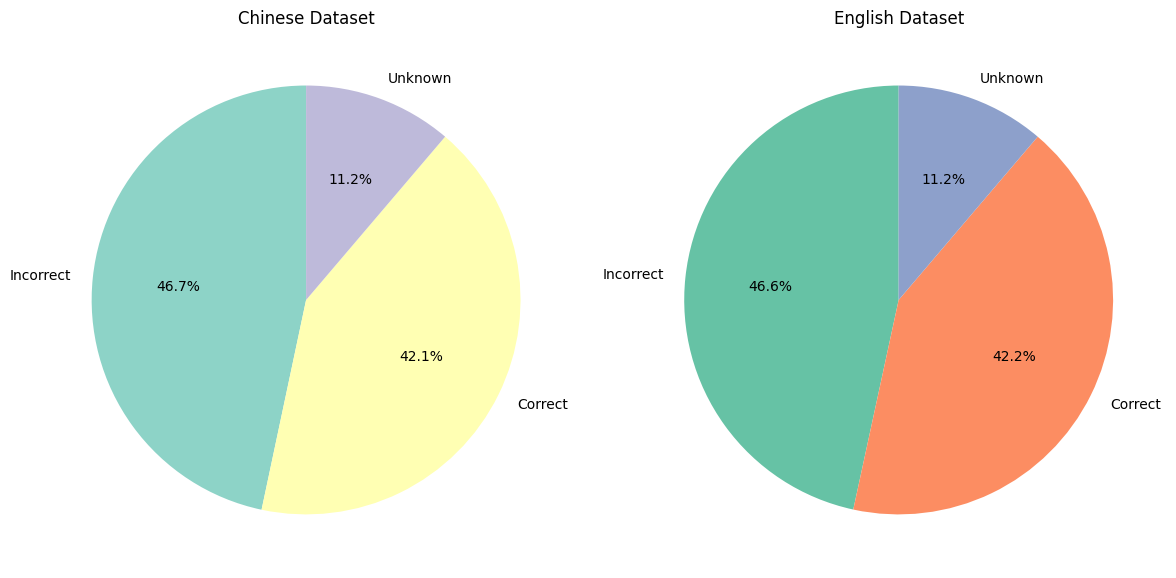

In [54]:
 # Plot distribution of labels for both languages using pie charts
en_counts = en_cases['label'].value_counts()
zh_counts = zh_cases['label'].value_counts()

colors_en = sns.color_palette('Set2', len(en_counts))
colors_zh = sns.color_palette('Set3', len(zh_counts))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

zh_counts.index = ['Incorrect', 'Correct', 'Unknown']
ax[0].pie(zh_counts, labels=zh_counts.index, autopct='%1.1f%%', startangle=90, colors=colors_zh)
ax[0].set_title("Chinese Dataset")

ax[1].pie(en_counts, labels=en_counts.index, autopct='%1.1f%%', startangle=90, colors=colors_en)
ax[1].set_title("English Dataset")

plt.tight_layout()
plt.show()

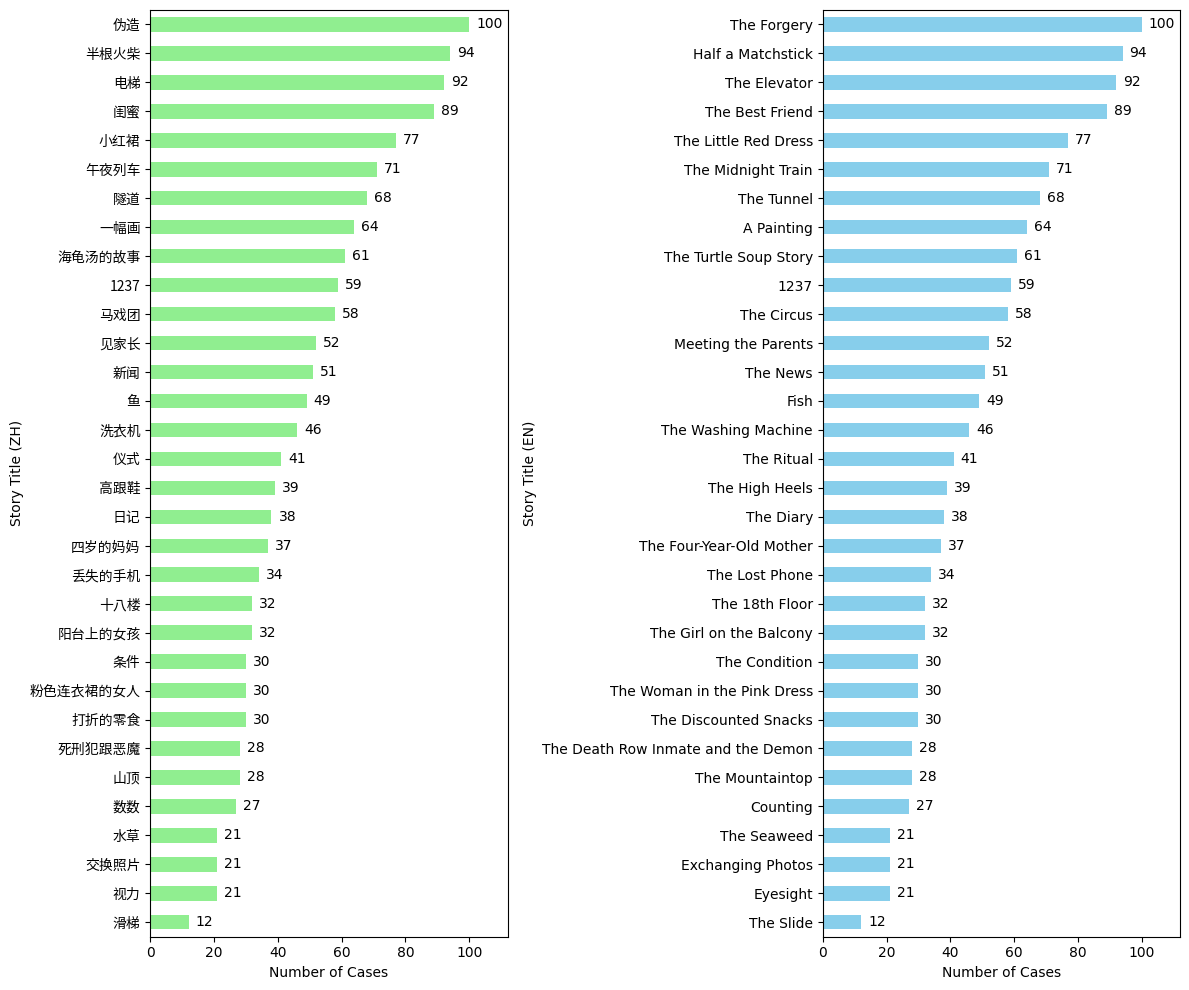

In [62]:
# Plot distribution of titles for both languages using horizontal bar charts
en_titles = en_cases['title'].value_counts().sort_values(ascending=True)
zh_titles = zh_cases['title'].value_counts().sort_values(ascending=True)


fig, ax = plt.subplots(1, 2, figsize=(12, 10))

zh_titles.plot(kind='barh', ax=ax[0], color='lightgreen')
ax[0].set_ylabel('Story Title (ZH)')
ax[0].set_xlabel('Number of Cases')

en_titles.plot(kind='barh', ax=ax[1], color='skyblue')
ax[1].set_ylabel('Story Title (EN)')
ax[1].set_xlabel('Number of Cases')

ax[0].set_xlim(0, zh_titles.max() * 1.12)
ax[1].set_xlim(0, en_titles.max() * 1.12)

# Add text annotations
for i, v in enumerate(zh_titles.values):
    ax[0].annotate(f'{v}', xy=(v, i), xytext=(5, 0), textcoords='offset points', ha='left', va='center')
for i, v in enumerate(en_titles.values):
    ax[1].annotate(f'{v}', xy=(v, i), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

for label in ax[0].get_yticklabels():
    label.set_fontproperties(font)

plt.tight_layout()
plt.show()

## Results Analysis

### Logs

In [4]:
def load_logs(model_name, language, shot_type):
    logs = []
    filename_prefix = f"all_cases_{model_name}_{language}_shot{shot_type}"
    
    if language == "zh":
        log_folder = f"./logs/zh_with_{shot_type}shots"
    else:
        log_folder = f"./logs/en_with_{shot_type}shots"

    # Find all log files for the model
    log_files = glob.glob(os.path.join(log_folder, f"{filename_prefix}_*.json"))

    if not log_files:
        print(f"No logs found for model: {model_name}")
        return None

    for log_file in sorted(log_files):
        with open(log_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            logs.append(data['overall'])

    return logs

In [7]:
def plot_accuracy_trend(zh_accuracies, en_accuracies, model_name, smoothing_window=5):
    # Create subplots: 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Apply moving average to smooth the trends for both zh and en
    zh_accuracies_smoothed = np.convolve(zh_accuracies, np.ones(smoothing_window)/smoothing_window, mode='valid')
    en_accuracies_smoothed = np.convolve(en_accuracies, np.ones(smoothing_window)/smoothing_window, mode='valid')

    # Determine consistent y-axis limits
    min_acc = min(min(zh_accuracies), min(en_accuracies))
    max_acc = max(max(zh_accuracies), max(en_accuracies))
    y_min, y_max = min_acc - 0.1, 1  # Add small margins

    # Plot Chinese data on the left subplot (ax1)
    ax1.plot(range(1, len(zh_accuracies) + 1), zh_accuracies, marker='o', linestyle='-', color='#1f77b4', label='Original Accuracy', alpha=0.7)
    ax1.plot(range(smoothing_window, len(zh_accuracies) + 1), zh_accuracies_smoothed, marker='o', linestyle='-', color='#ff7f0e', label=f'Smoothed (window={smoothing_window})')
    ax1.set_title(f'{model_name} - Chinese Data (zh)', fontsize=16)
    ax1.set_xlabel('Log Index', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim([y_min, y_max])  # Set consistent y-axis limits
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='best')

    # Plot English data on the right subplot (ax2)
    ax2.plot(range(1, len(en_accuracies) + 1), en_accuracies, marker='o', linestyle='-', color='#2ca02c', label='Original Accuracy', alpha=0.7)
    ax2.plot(range(smoothing_window, len(en_accuracies) + 1), en_accuracies_smoothed, marker='o', linestyle='-', color='#d62728', label=f'Smoothed (window={smoothing_window})')
    ax2.set_title(f'{model_name} - English Data (en)', fontsize=16)
    ax2.set_xlabel('Log Index', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_ylim([y_min, y_max])  # Set consistent y-axis limits
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='best')

    # Adjust layout
    plt.tight_layout()
    plt.show()

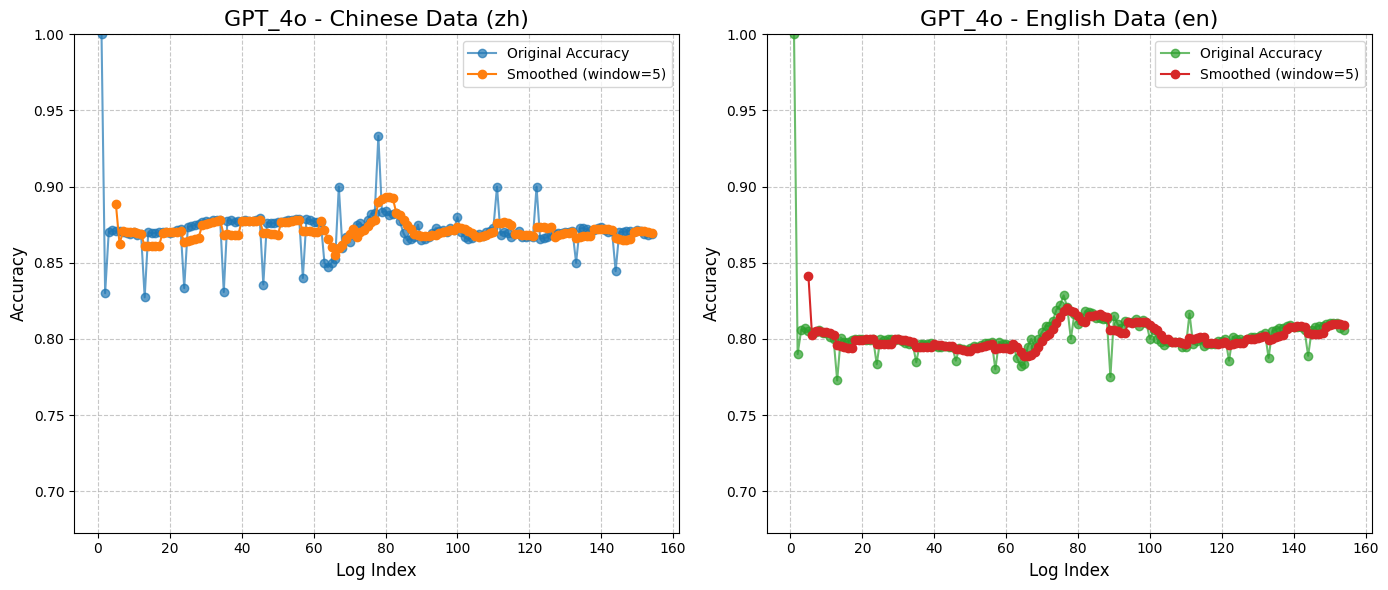

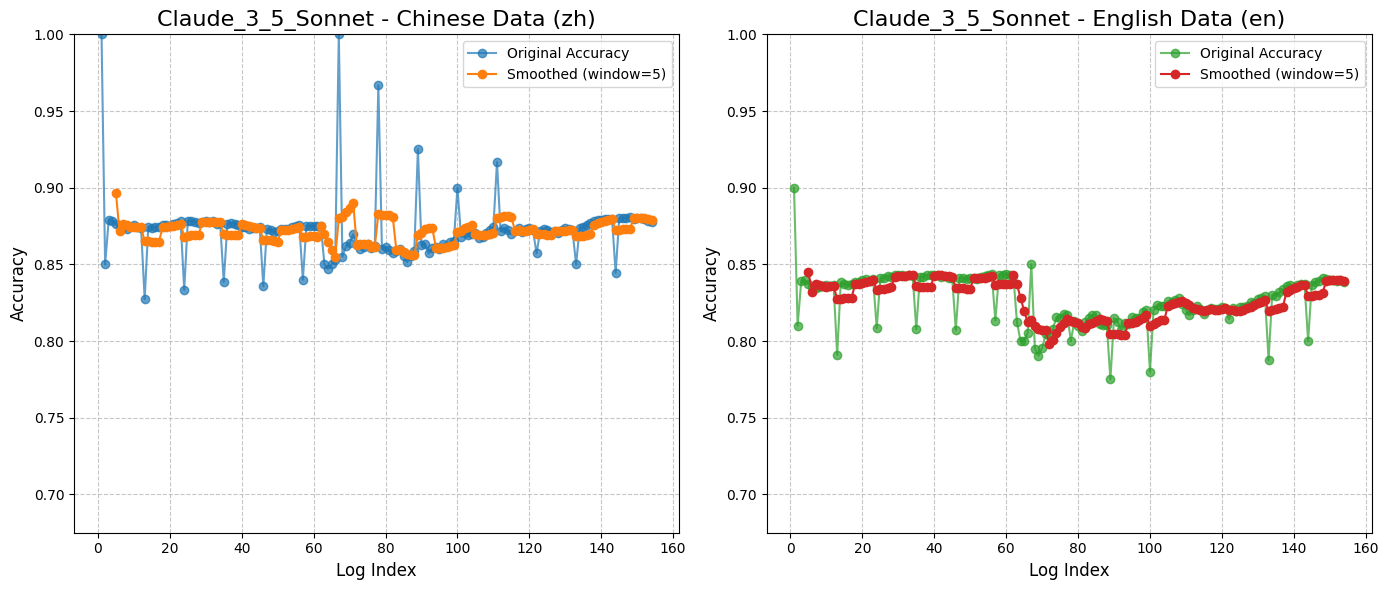

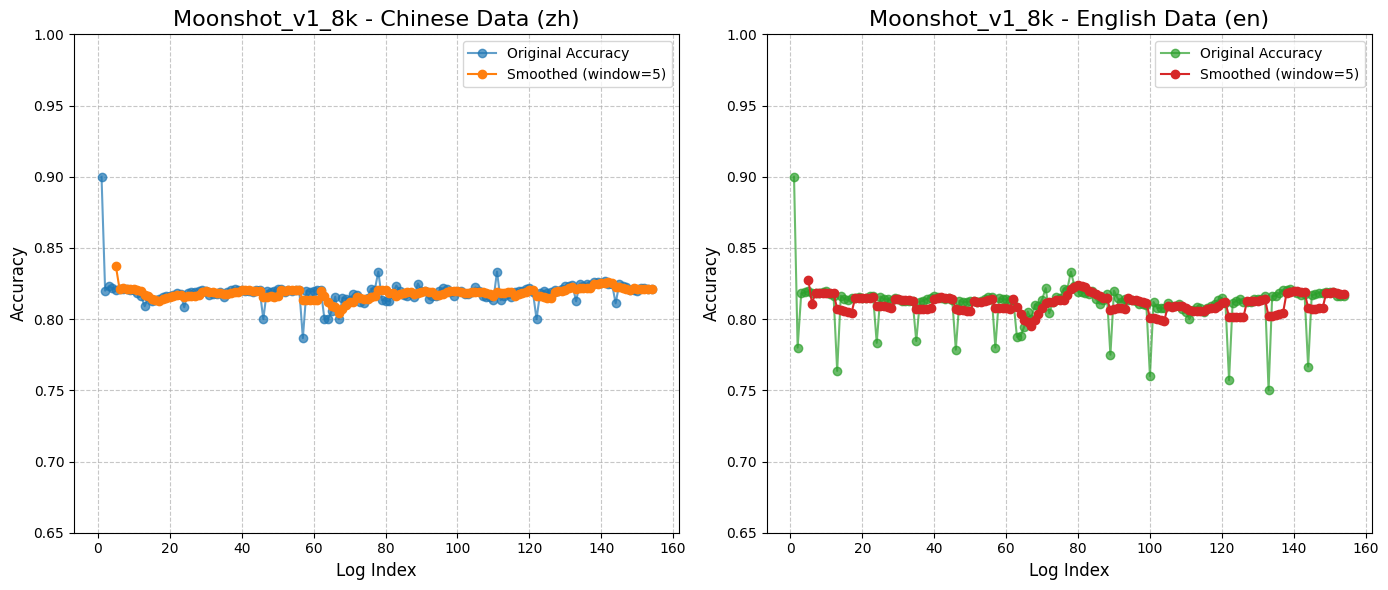

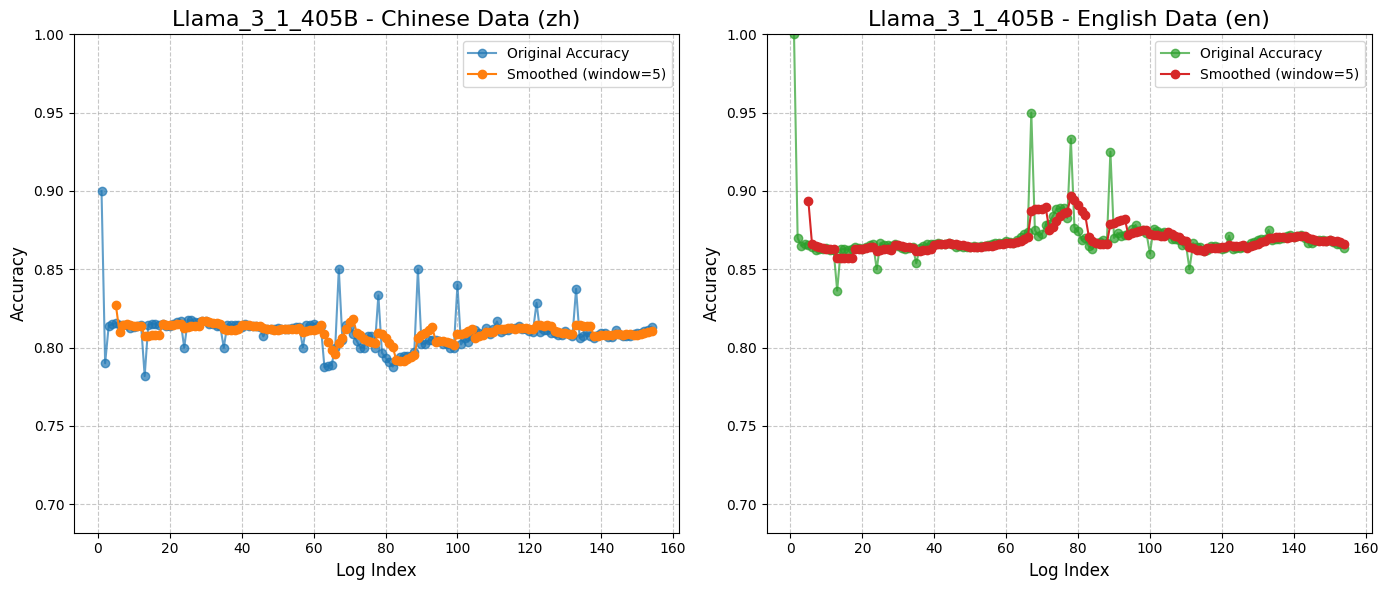

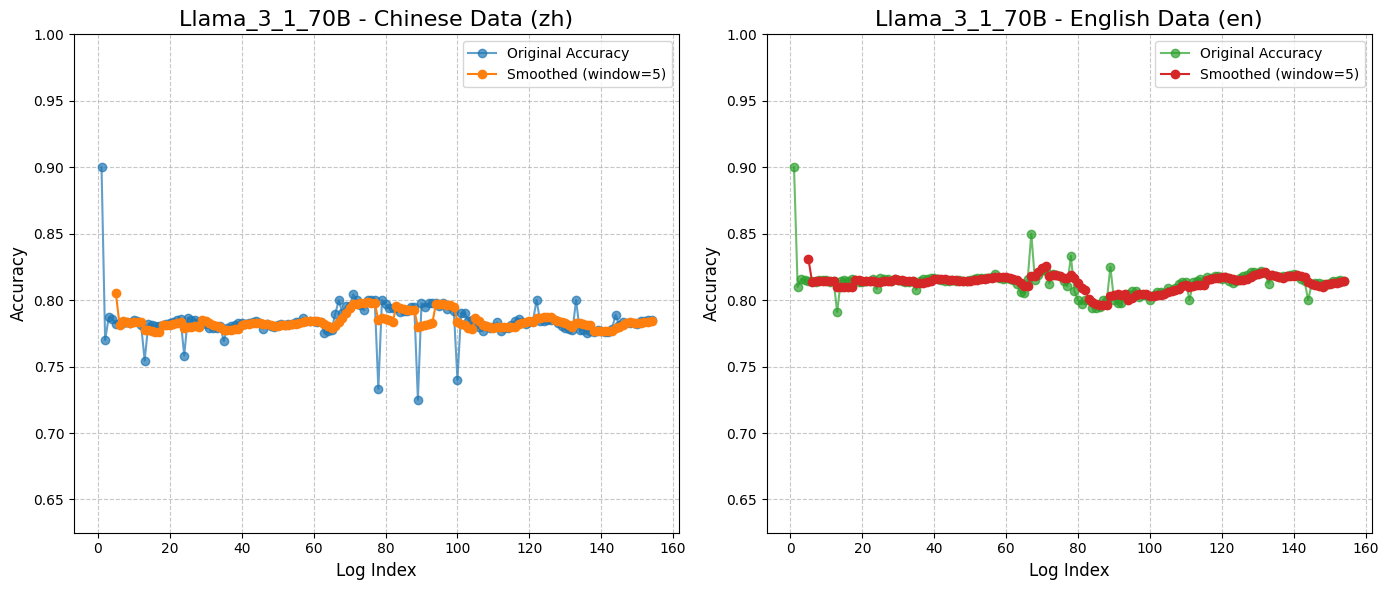

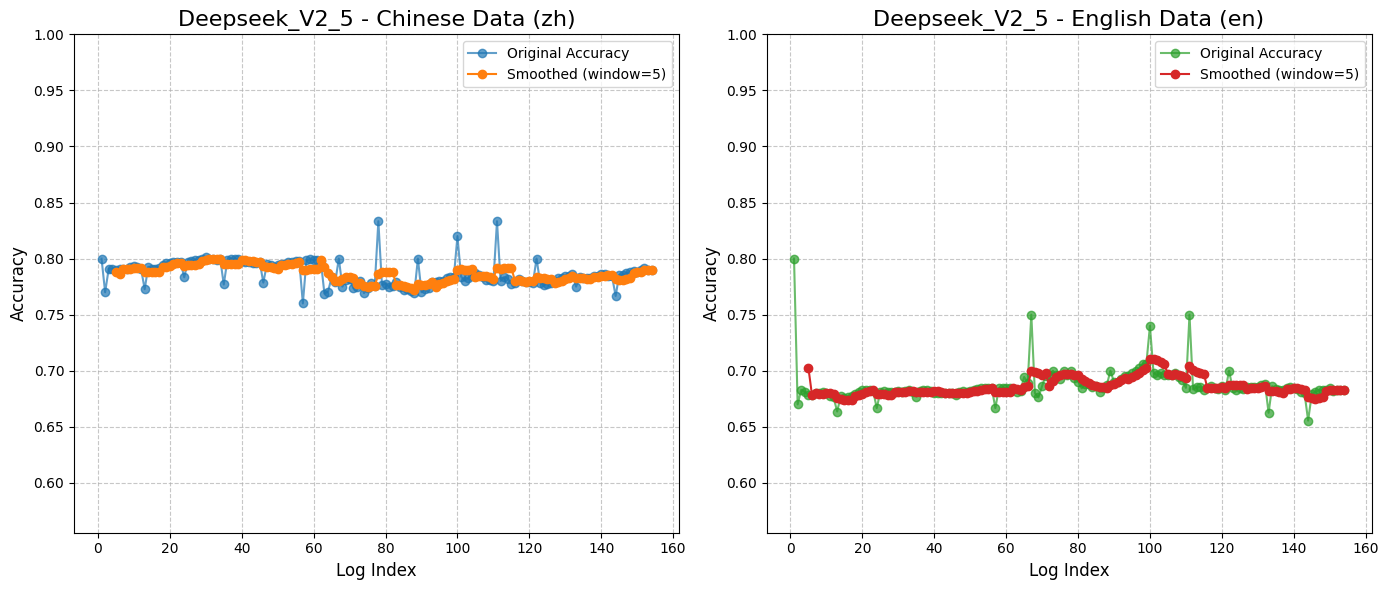

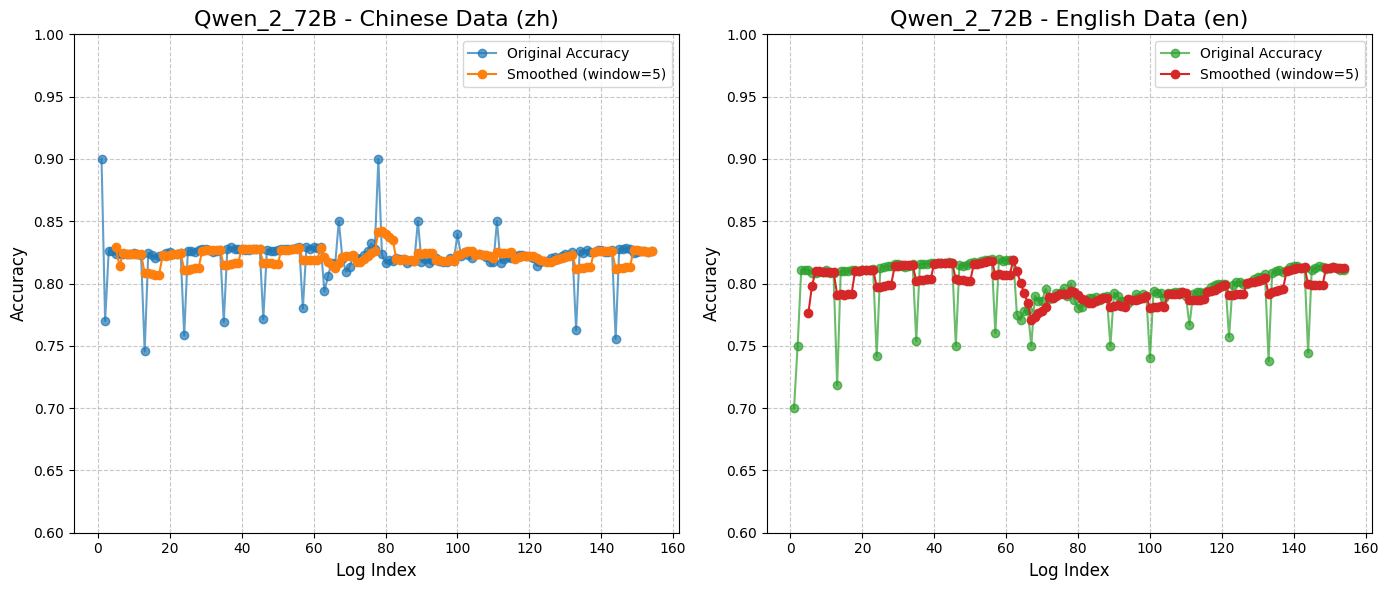

In [8]:
MODEL_NAMES = [
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

for model_name in MODEL_NAMES:
    # Load logs for Chinese and English (0 shots)
    zh_logs_0shot = load_logs(model_name, "zh", "0")
    en_logs_0shot = load_logs(model_name, "en", "0")

    # Extract accuracies from the logs
    zh_accuracies = [log['accuracy'] for log in zh_logs_0shot]
    en_accuracies = [log['accuracy'] for log in en_logs_0shot]

    # Plot the accuracy trends for both Chinese and English data
    plot_accuracy_trend(zh_accuracies, en_accuracies, model_name, smoothing_window=5)

### Finial Results

In [9]:
def load_latest_cases(model_name, language, shot_type):
    """Load the latest cases."""
    filename_prefix = f"all_cases_{model_name}_{language}_shot{shot_type}"
    
    if language == "zh":
        log_folder = f"./logs/zh_with_{shot_type}shots"
    else:
        log_folder = f"./logs/en_with_{shot_type}shots"

    # Find all log files for the model
    log_files = glob.glob(os.path.join(log_folder, f"{filename_prefix}_*.json"))

    if not log_files:
        print(f"No log files found for model {model_name} in {log_folder}.")
        return None

    # Sort log files by the numerical part at the end of the filename
    log_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)

    # Load the latest log file (the first one after sorting)
    latest_log_file = log_files[0]

    with open(latest_log_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data.get('cases', [])

In [44]:
from eval import is_correct
from collections import defaultdict

def calculate_story_accuracy(cases, language):
    story_stats = defaultdict(lambda: {'correct': 0, 'total': 0})
    total_correct = 0
    total_samples = len(cases)

    for case in cases:
        story_title = case["story_title"]
        model_judge = case["model_judge"]
        ground_truth = case["ground_truth"]

        correct = is_correct(model_judge, ground_truth, language)
        
        story_stats[story_title]['total'] += 1
        if correct:
            story_stats[story_title]['correct'] += 1
            total_correct += 1

    story_accuracies = {}
    for story_title, stats in story_stats.items():
        accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0
        story_accuracies[story_title] = accuracy

    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    average_story_accuracy = sum(story_accuracies.values()) / len(story_accuracies) if story_accuracies else 0.0

    return story_accuracies, overall_accuracy, average_story_accuracy

In [47]:
def visualize_accuracy_comparison(model_name, zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy, 
                                  en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy, zh_cases, en_cases):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    # Create a defaultdict to count the number of cases per story for ZH and EN data
    zh_story_counts = defaultdict(int)
    for case in zh_cases:
        zh_story_counts[case['story_title']] += 1

    en_story_counts = defaultdict(int)
    for case in en_cases:
        en_story_counts[case['story_title']] += 1

    # Update stories with the format 'Story Title (count)'
    stories_zh = [f"{story} ({zh_story_counts[story]})" for story in zh_story_accuracies.keys()]
    accuracies_zh = list(zh_story_accuracies.values())
    
    stories_en = [f"{story} ({en_story_counts[story]})" for story in en_story_accuracies.keys()]
    accuracies_en = list(en_story_accuracies.values())

    # Set min and max values for y-axis limits
    min_accuracy = min(min(accuracies_zh), min(accuracies_en), zh_overall_accuracy, en_overall_accuracy, zh_avg_story_accuracy, en_avg_story_accuracy)
    y_min = max(0.5, min_accuracy - 0.05)
    y_max = 1.0

    # Plot for Chinese stories
    bars_zh = ax1.barh(stories_zh, accuracies_zh, color='skyblue', label='story accuracy')
    ax1.axvline(zh_overall_accuracy, color='red', linewidth=2, linestyle='--', label='total accuracy')
    ax1.axvline(zh_avg_story_accuracy, color='green', linewidth=2, linestyle='--', label='average story accuracy')
    
    for bar in bars_zh:
        width = bar.get_width()
        ax1.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0), textcoords="offset points", ha='left', va='center')

    ax1.set_yticks(range(len(stories_zh)))
    ax1.set_yticklabels(stories_zh, fontproperties=font)

    ax1.set_xlabel('Accuracy', fontsize=12)
    ax1.set_ylabel('Story Title (ZH)', fontsize=12)
    ax1.set_title(f'{model_name} - Chinese Data (ZH)', fontsize=14)
    ax1.set_xlim([y_min, y_max])
    ax1.legend()

    # Plot for English stories
    bars_en = ax2.barh(stories_en, accuracies_en, color='lightgreen', label='Story Accuracy')
    ax2.axvline(en_overall_accuracy, color='red', linewidth=2, linestyle='--', label='Overall Accuracy')
    ax2.axvline(en_avg_story_accuracy, color='green', linewidth=2, linestyle='--', label='Average Story Accuracy')
    
    for bar in bars_en:
        width = bar.get_width()
        ax2.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0), textcoords="offset points", ha='left', va='center')

    ax2.set_xlabel('Accuracy', fontsize=12)
    ax2.set_ylabel('Story Title (EN)', fontsize=12)
    ax2.set_title(f'{model_name} - English Data (EN)', fontsize=14)
    ax2.set_xlim([y_min, y_max])
    ax2.legend()

    plt.tight_layout()
    plt.show()

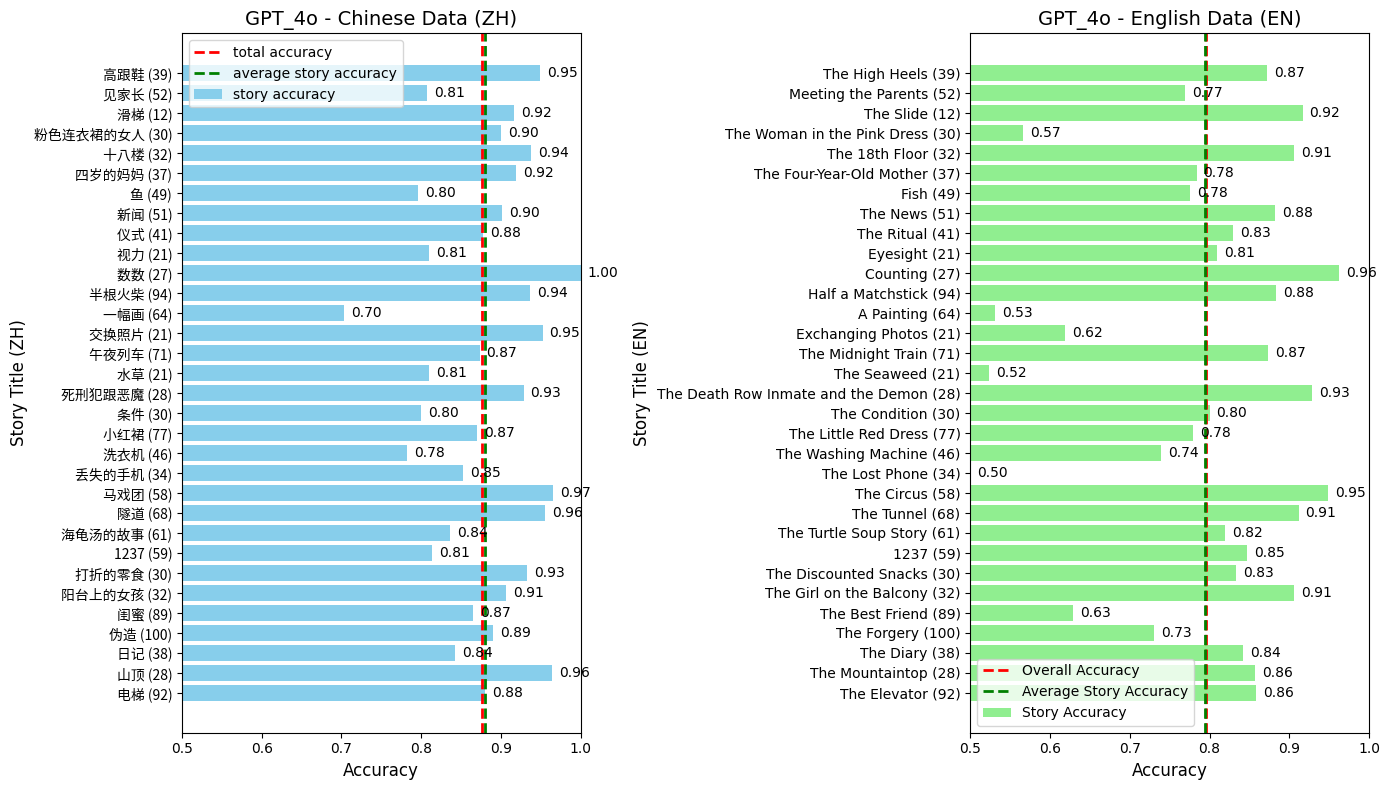

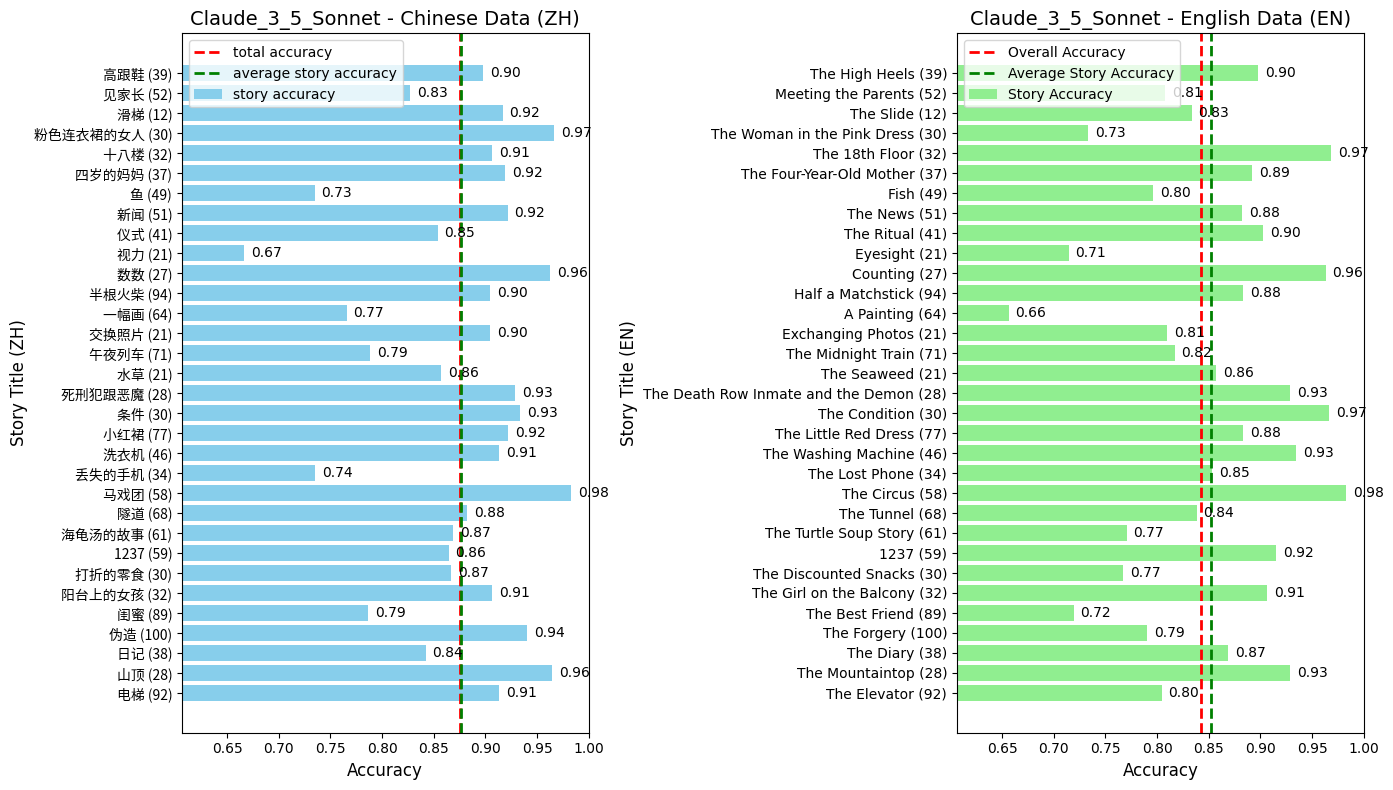

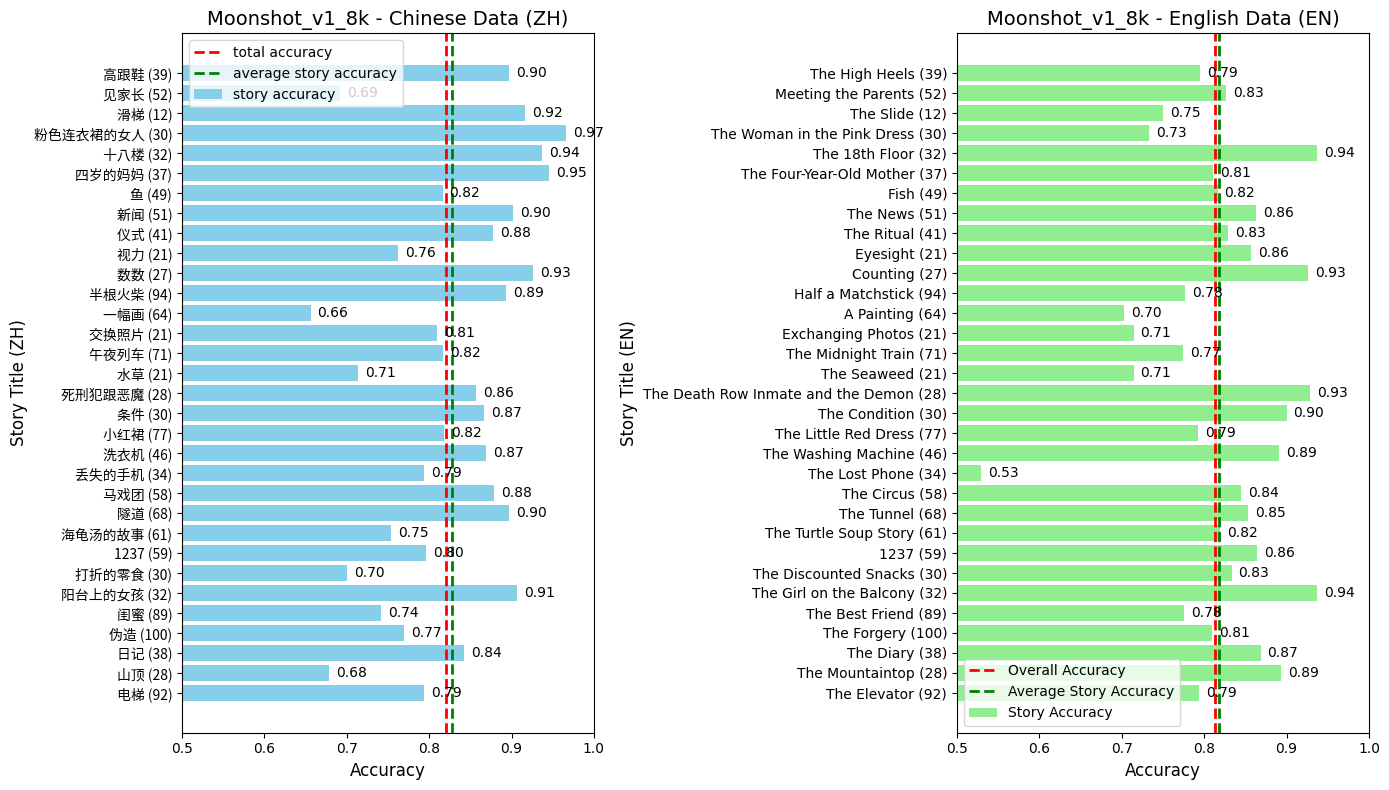

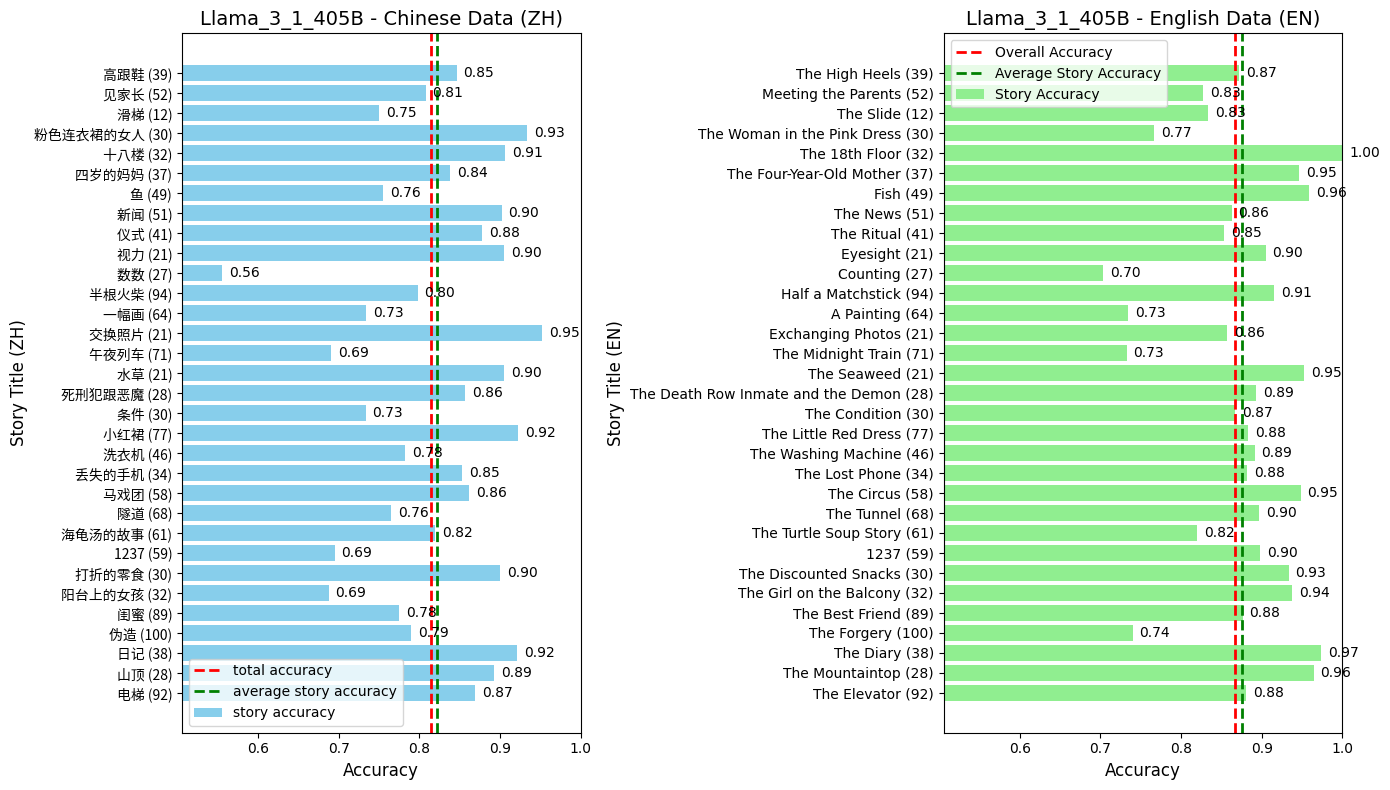

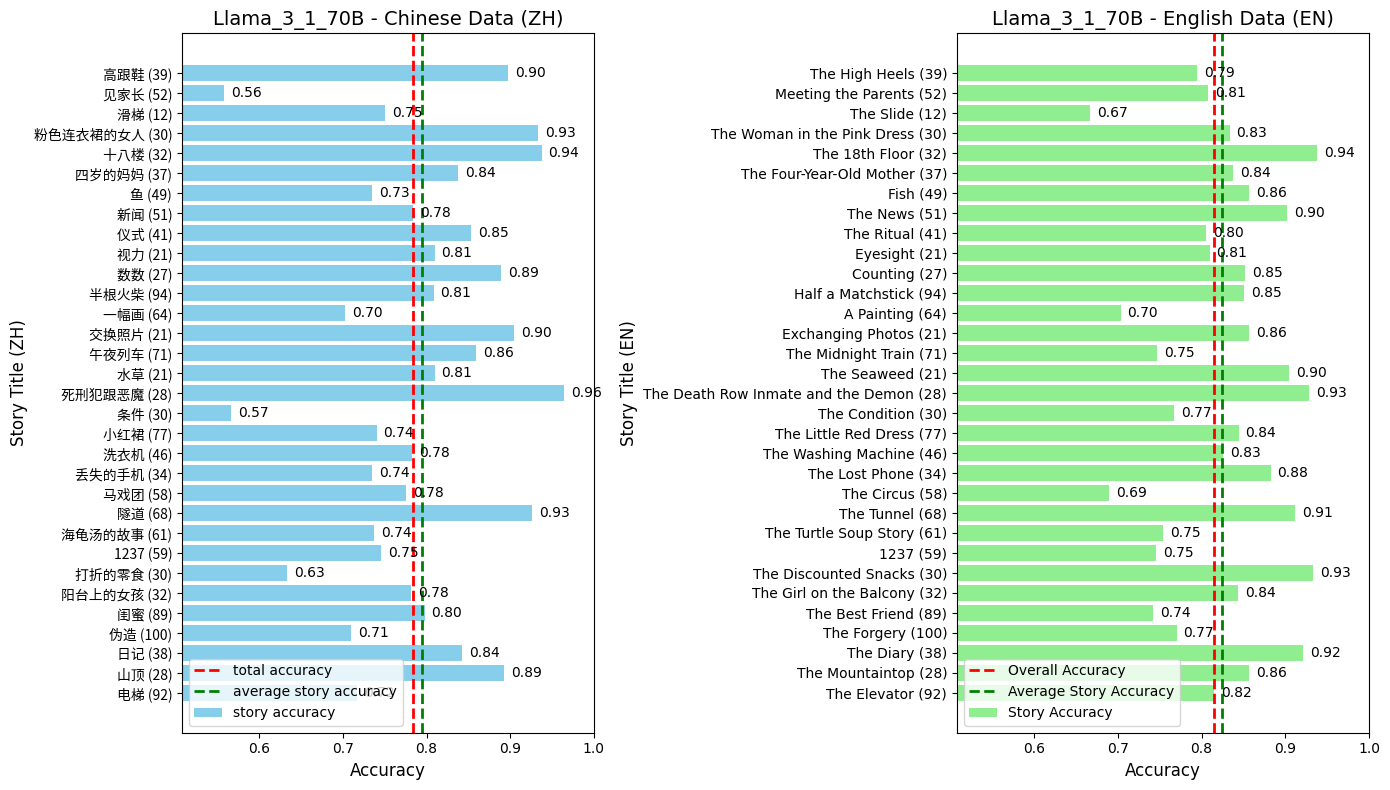

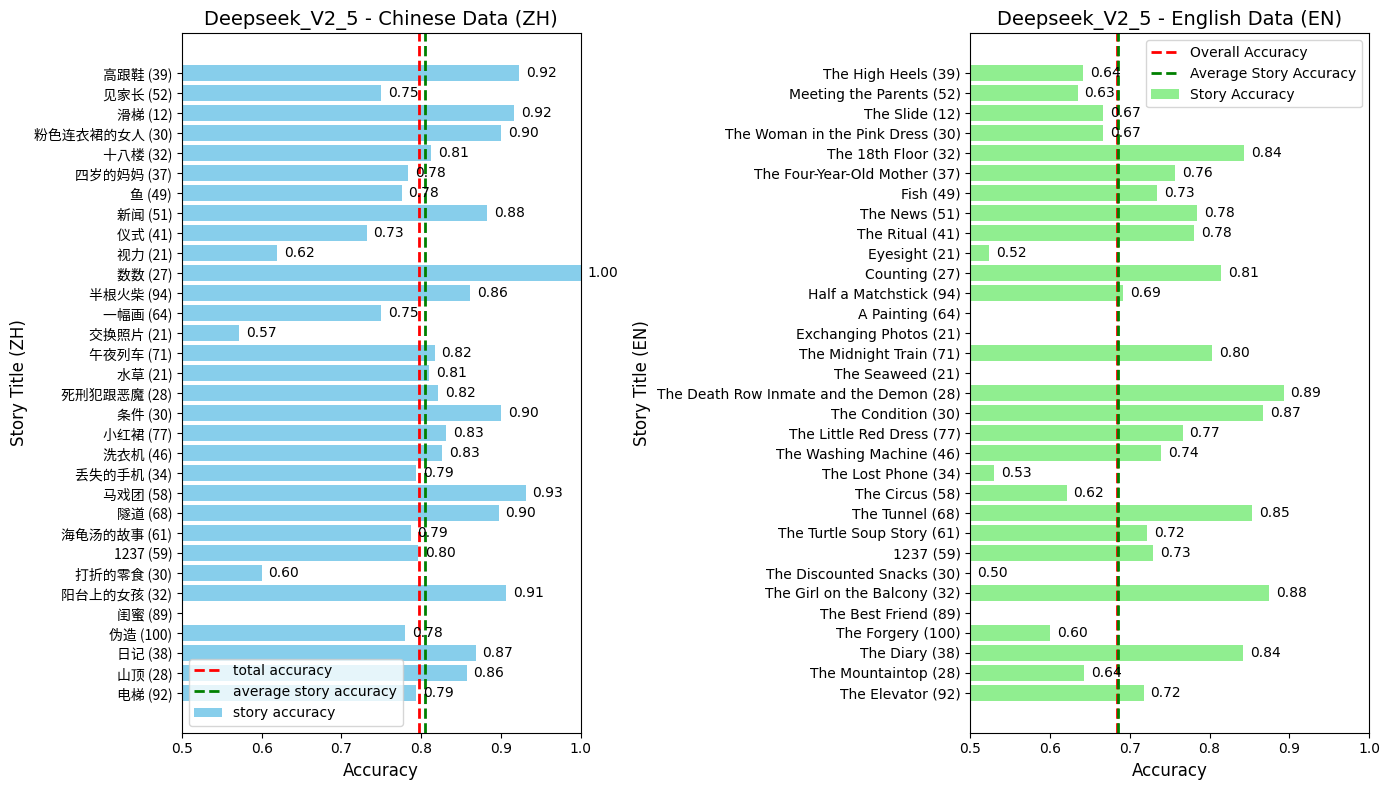

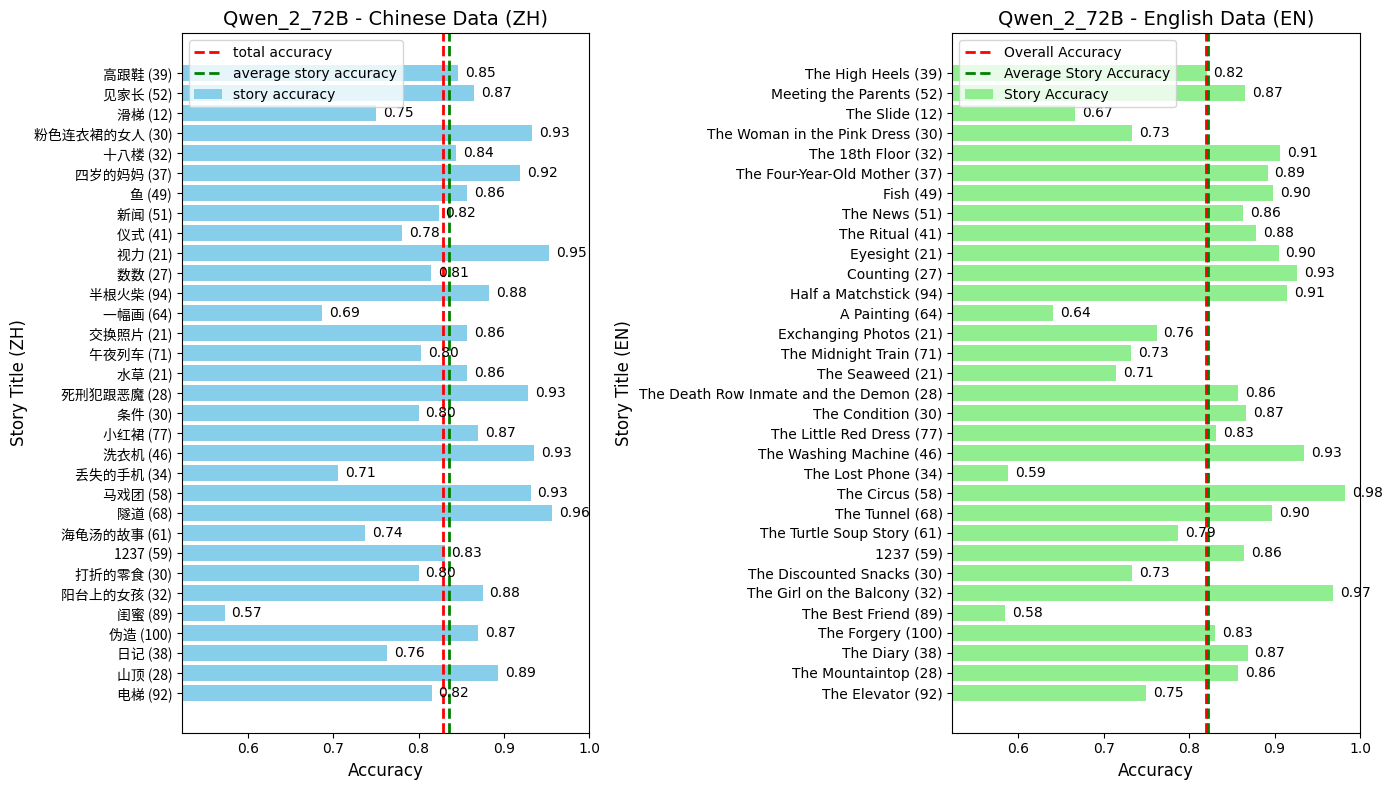

In [48]:
MODEL_NAMES = [
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

for model_name in MODEL_NAMES:
    zh_cases = load_latest_cases(model_name, "zh", "0")
    en_cases = load_latest_cases(model_name, "en", "0")

    zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy = calculate_story_accuracy(zh_cases, "zh")
    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy = calculate_story_accuracy(en_cases, "en")

    visualize_accuracy_comparison(model_name, zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy,
                                    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy,
                                    zh_cases, en_cases)


In [42]:
def visualize_accuracy_difference(model_name, zh_story_accuracies, en_story_accuracies):
    stories_en = list(en_story_accuracies.keys())
    accuracies_zh = list(zh_story_accuracies.values())
    accuracies_en = list(en_story_accuracies.values())
    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(accuracies_zh, accuracies_en, color='skyblue', label='Stories', s=60)
    ax.plot([0.65, 1], [0.65, 1], linestyle='--', color='red', label='ZH = EN')

    texts = []
    for i, story in enumerate(stories_en):
        texts.append(ax.annotate(story, (accuracies_zh[i], accuracies_en[i]), fontsize=6))
    
    adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, autoalign='xy', expand_points=(1.2, 1.2))
    
    ax.set_xlim([0.65, 1.03])
    ax.set_ylim([0.65, 1.03])
    ax.set_xticks([0.7, 0.8, 0.9, 1])
    ax.set_yticks([0.7, 0.8, 0.9, 1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel('ZH Accuracy', fontsize=12)
    ax.set_ylabel('EN Accuracy', fontsize=12)

    ax.set_title(f'{model_name} - Chinese vs. English Dataset', fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.show()

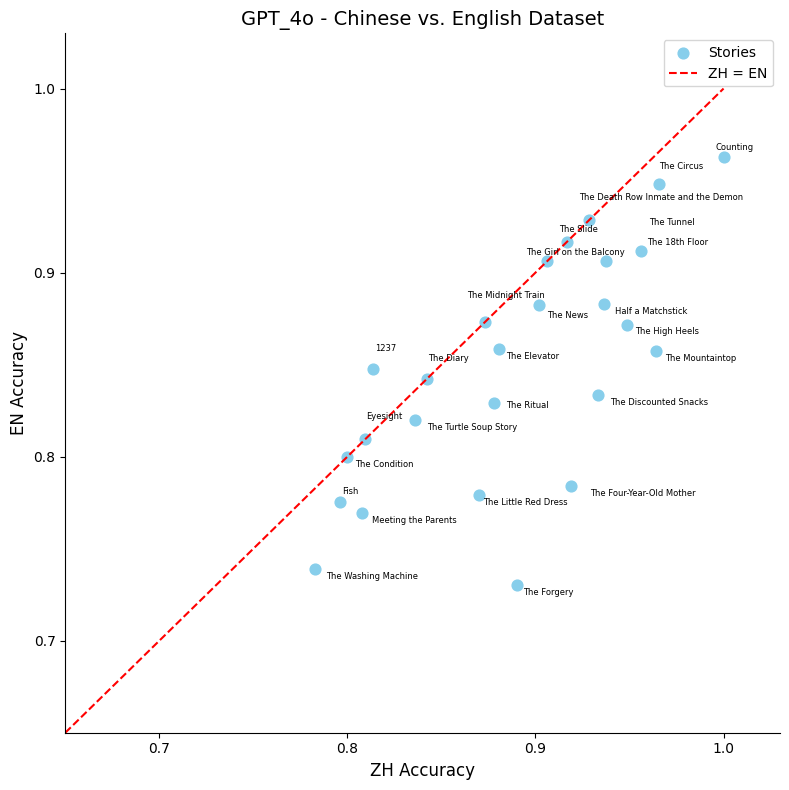

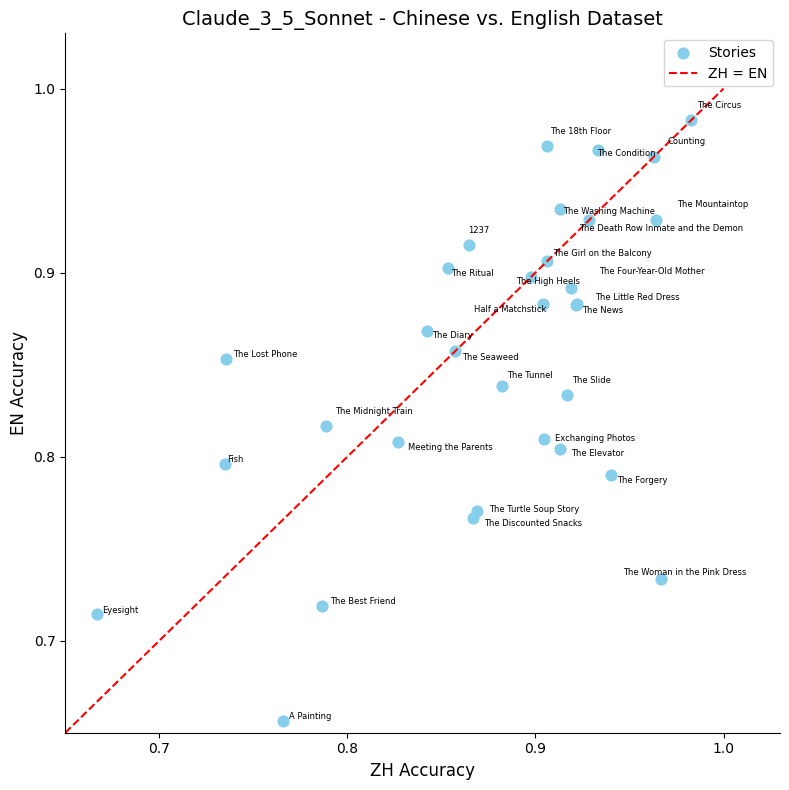

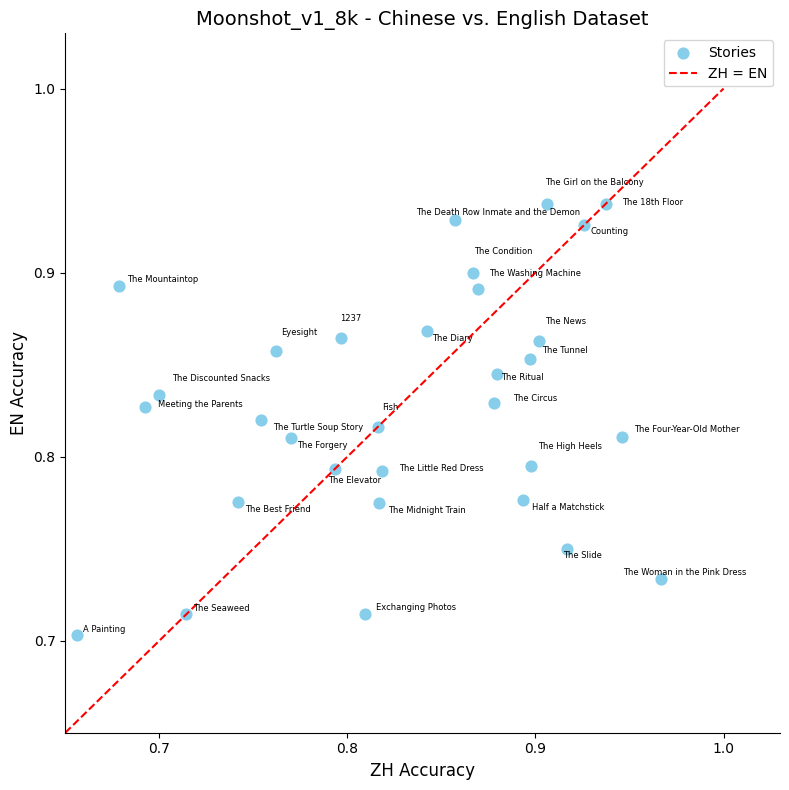

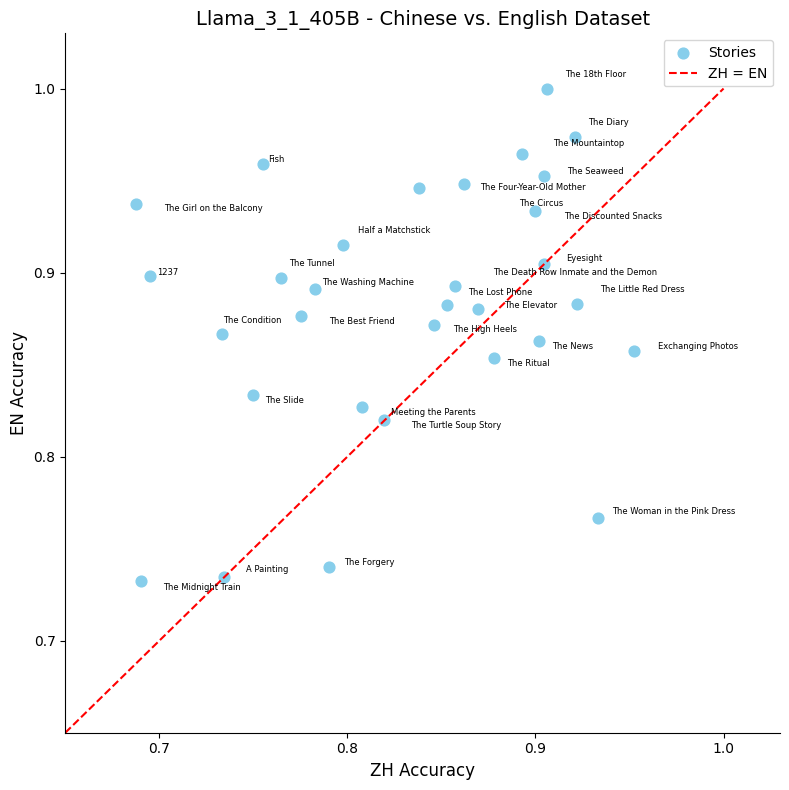

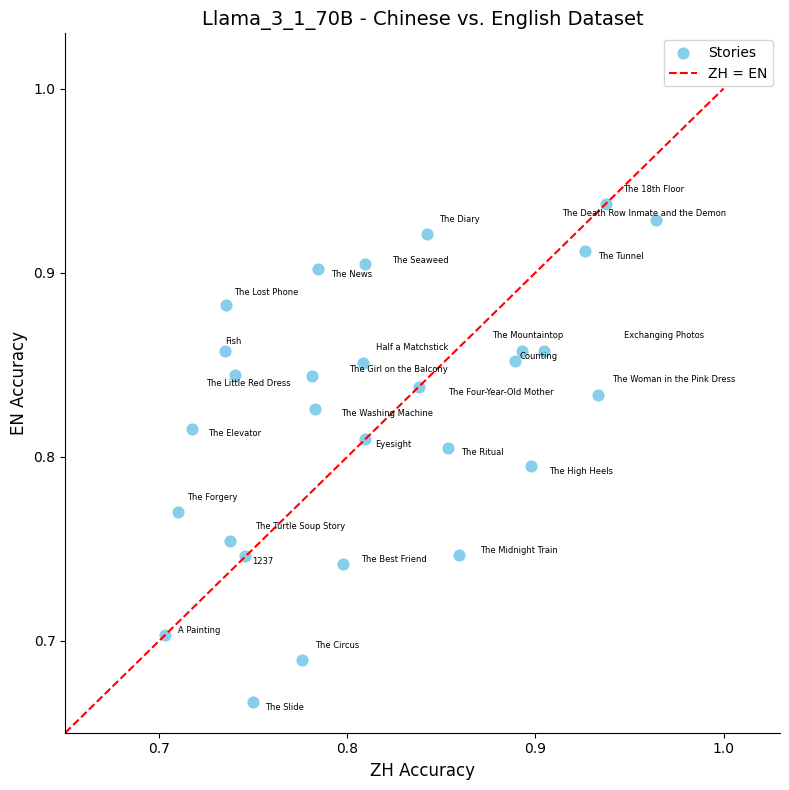

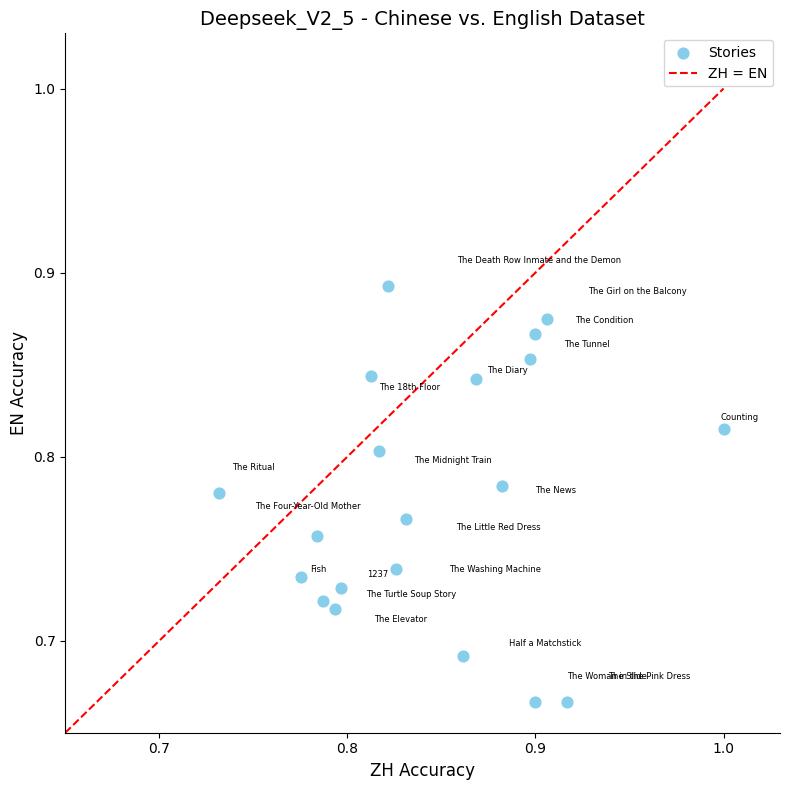

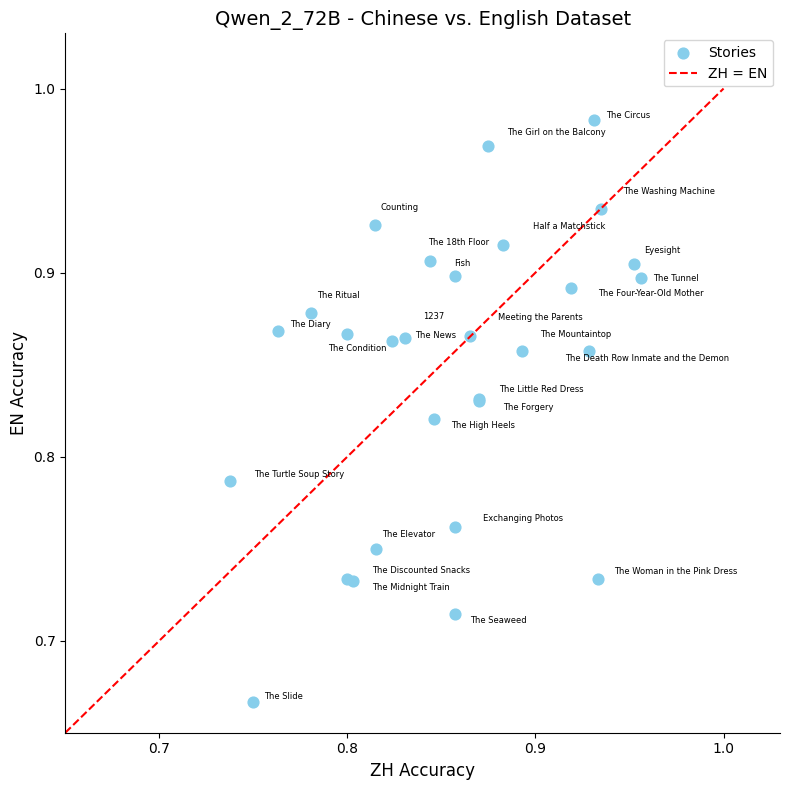

In [43]:
MODEL_NAMES = [
    'GPT_4o',
    'Claude_3_5_Sonnet',
    'Moonshot_v1_8k',
    'Llama_3_1_405B',
    'Llama_3_1_70B',
    'Deepseek_V2_5',
    'Qwen_2_72B'
]

for model_name in MODEL_NAMES:
    zh_cases = load_latest_cases(model_name, "zh", "0")
    en_cases = load_latest_cases(model_name, "en", "0")

    zh_story_accuracies, zh_overall_accuracy, zh_avg_story_accuracy = calculate_story_accuracy(zh_cases, "zh")
    en_story_accuracies, en_overall_accuracy, en_avg_story_accuracy = calculate_story_accuracy(en_cases, "en")
    visualize_accuracy_difference(model_name, zh_story_accuracies, en_story_accuracies)
